# **Movies Dataset Exploratory Data Analysis**

## **Collaborators** 
- Ashna Sood 
- Urmi Suresh
- Tae Kim 
- Xianglong Wang

## **Imports** 

In [68]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os 
import pickle
import math

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer

from sklearn import metrics

## **Data Cleaning**

In [69]:
# read in movies metadata 
movies_df = pd.read_csv('Movies Data/movies_metadata.csv')

# drop unecessary metadata
movies_df = movies_df.drop(columns=["adult", "budget", "homepage", "original_title", "overview", "poster_path", "status", "tagline", "video"])


# change column names
movies_df = movies_df.rename(columns={"belongs_to_collection":"Collection", 
                                      "genres":"Genres", 
                                      "id":"ID", 
                                      "imdb_id":"IMDB ID", 
                                      "original_language":"Language", 
                                      "popularity":"Popularity Rating", 
                                      "production_companies":"Production Companies", 
                                      "production_countries":"Production Countries", 
                                      "release_date":"Release Date", 
                                      "revenue":"Revenue", "runtime":"Runtime", 
                                      "spoken_languages":"Spoken Languages", 
                                      "title":"Title", 
                                      "vote_average":"Vote Average", 
                                      "vote_count":"Vote Count"})

# remove duplicate movies present in the df keeping the movie with a higher vote count
movies_df = movies_df.sort_values('Vote Count').drop_duplicates('Title', keep='last')

# reorder columns 
movies_df = movies_df[["ID", "IMDB ID", "Title", "Collection", "Genres", "Language", "Spoken Languages", "Release Date", 
                       "Runtime", "Revenue", "Production Companies", "Production Countries", 
                       "Popularity Rating", "Vote Count", "Vote Average"]]

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average
45465,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.000000e+00,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0
23677,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,0.000000e+00,[],[],0.3265,0.0,0.0
23671,114838,tt0029949,Brother Rat,NaN,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1938-10-29,87.0,0.000000e+00,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.174691,0.0,0.0
23663,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,0.000000e+00,[],[],0.000115,0.0,0.0
23648,88061,tt0055459,"So Evil, So Young",NaN,"[{'id': 18, 'name': 'Drama'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1963-01-01,77.0,0.000000e+00,[],[],0.001662,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17818,24428,tt0848228,The Avengers,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2012-04-25,143.0,1.519558e+09,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",89.887648,12000.0,7.4
14551,19995,tt0499549,Avatar,"{'id': 87096, 'name': 'Avatar Collection', 'po...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2009-12-10,162.0,2.787965e+09,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",185.070892,12114.0,7.2
12481,155,tt0468569,The Dark Knight,"{'id': 263, 'name': 'The Dark Knight Collectio...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2008-07-16,152.0,1.004558e+09,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",123.167259,12269.0,8.3
15480,27205,tt1375666,Inception,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2010-07-14,148.0,8.255328e+08,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",29.108149,14075.0,8.1


In [70]:
# read in movie keywords
keywords_df = pd.read_csv('Movies Data/keywords.csv')

# rename columns
keywords_df = keywords_df.rename(columns={"id": "ID", 
                                          "keywords": "Keywords"})

# read in movie credits 
credits_df = pd.read_csv('Movies Data/credits.csv')

# rename columns
credits_df = credits_df.rename(columns={"cast": "Cast", 
                                        "crew": "Crew",
                                        "id": "ID"})

In [71]:
# merge tables
movies_df['ID'] = movies_df['ID'].astype(str)
keywords_df['ID'] = keywords_df['ID'].astype(str)
credits_df['ID'] = credits_df['ID'].astype(str)

movies_df = movies_df.merge(keywords_df, on="ID", how="left").merge(credits_df, on="ID", how="left")
movies_df.head(1)

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Crew
0,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.0,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0,[],[],"[{'credit_id': '593e676c92514105b702e68e', 'de..."


In [72]:
# cast types
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'], errors='coerce')
movies_df['Popularity Rating'] = pd.to_numeric(movies_df['Popularity Rating'], errors='coerce')
movies_df['Vote Count'] = movies_df['Vote Count'].astype(np.int64, errors='ignore')

# replace unreasonable values with NaN
movies_df['Revenue'] = movies_df['Revenue'].replace(0, np.nan)
movies_df['Popularity Rating'] = movies_df['Popularity Rating'].replace(0, np.nan)
movies_df['Vote Count'] = movies_df['Vote Count'].replace(0, np.nan)
movies_df['Vote Average'] = movies_df['Vote Average'].replace(0, np.nan)

In [73]:
# method to extract the director, screenplay writer, and producer from each movie
def extract_crew(crew):
    director, writer, producer = None, None, None
    for each in crew:

        if director and writer and producer:
            return [director, writer, producer]

        try:
            if (not director) and each['department']=='Directing' and each['job']=='Director':
                director = each['name']
                continue
                
        except:
          ...

        try:
            if (not writer) and each['department']=='Writing' and each['job']=='Screenplay' or each['job']=='Writer':
                writer = each['name']
                continue
        except:
            ...

        try:
            if (not producer) and each['department']=='Production' and (each['job']=='Producer' or each['job']=='Executive Producer'):
                producer = each['name']
                continue
        except:
            ...

    return [director, writer, producer]

In [74]:
# convert the Collections string literal into a dict and extract the name of the franchise 
movies_df["Collection"] = movies_df['Collection'].fillna('[]').apply(ast.literal_eval).apply(lambda x: x["name"] if isinstance(x, dict) else np.nan)

# extract genres out of string literal
movies_df['Genres'] = movies_df['Genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract spoken languages out of string literal
movies_df['Spoken Languages'] = movies_df['Spoken Languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Company out of string literal
movies_df['Production Companies'] = movies_df['Production Companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Countries out of string literal
movies_df['Production Countries'] = movies_df['Production Countries'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the keywords for each movie
movies_df["Keywords"] = movies_df["Keywords"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the names of at most the top 5 actors in each movie
movies_df["Cast"] = movies_df["Cast"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)
movies_df["Cast"] = movies_df["Cast"].apply(lambda x: x[:5] if len(x) > 5 else x)

# conver the Crew string literal into dict and extract the director, screenplay writer, and producer of each movie 
movies_df["Crew"] = movies_df["Crew"].fillna('[]').apply(ast.literal_eval)
movies_df['Director'], movies_df['Writer'], movies_df['Producer'] = [*zip(*np.array(movies_df['Crew'].apply(extract_crew)))]
movies_df = movies_df.drop('Crew', axis=1)

movies_df = movies_df.fillna(value=np.nan)

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


In [75]:
# drop duplicates 
movies_df = movies_df.drop_duplicates(subset=["Title"])
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


## **Movies Metadata EDA**

In [106]:
movies_original = pd.read_csv('Movies Data/movies_metadata.csv') # the dataset before cleaning
movi

In [107]:
#calculate the correlation between variable
charges = movies_original.iloc[:,1:23]
corrDf = charges.apply(lambda x: pd.factorize(x)[0])
corrDf .head()
corrDf.info()
corr = corrDf.corr()
corr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   belongs_to_collection  45466 non-null  int64
 1   budget                 45466 non-null  int64
 2   genres                 45466 non-null  int64
 3   homepage               45466 non-null  int64
 4   id                     45466 non-null  int64
 5   imdb_id                45466 non-null  int64
 6   original_language      45466 non-null  int64
 7   original_title         45466 non-null  int64
 8   overview               45466 non-null  int64
 9   popularity             45466 non-null  int64
 10  poster_path            45466 non-null  int64
 11  production_companies   45466 non-null  int64
 12  production_countries   45466 non-null  int64
 13  release_date           45466 non-null  int64
 14  revenue                45466 non-null  int64
 15  runtime                45466 non-nul

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average
belongs_to_collection,1.000000,0.029434,0.124663,0.038777,0.055991,0.055676,0.043644,0.063849,0.052284,0.058582,...,-0.012863,0.042721,0.079554,0.011783,0.015159,-0.001169,0.024811,0.068724,-0.012797,-0.026987
budget,0.029434,1.000000,0.027430,0.083901,-0.016124,-0.016293,0.048494,-0.017564,-0.010917,-0.013468,...,0.024950,0.025826,0.204724,-0.001509,0.065556,-0.011717,0.074917,-0.016989,-0.013164,-0.029333
genres,0.124663,0.027430,1.000000,0.082276,0.109683,0.108954,0.032461,0.097152,0.119095,0.110987,...,0.016350,0.082841,0.023328,0.035161,0.020274,0.004834,0.073024,0.095675,0.006007,0.003651
homepage,0.038777,0.083901,0.082276,1.000000,0.260788,0.260787,0.001457,0.247663,0.272953,0.264747,...,0.053937,0.283662,0.143976,0.017253,0.047741,0.026562,0.191672,0.245799,0.019790,0.002128
id,0.055991,-0.016124,0.109683,0.260788,1.000000,0.999200,0.155732,0.957487,0.926638,0.987505,...,0.128779,0.652092,-0.079361,0.168084,0.098666,0.044290,0.162857,0.931378,0.034823,0.175937
imdb_id,0.055676,-0.016293,0.108954,0.260787,0.999200,1.000000,0.155370,0.956762,0.926120,0.986877,...,0.128697,0.651912,-0.079049,0.168070,0.098818,0.044165,0.162994,0.930718,0.035760,0.175688
original_language,0.043644,0.048494,0.032461,0.001457,0.155732,0.155370,1.000000,0.165794,0.122518,0.152278,...,0.250433,0.066748,-0.044813,0.031997,0.458384,-0.001278,-0.112785,0.148343,-0.018645,-0.022265
original_title,0.063849,-0.017564,0.097152,0.247663,0.957487,0.956762,0.165794,1.000000,0.884458,0.944893,...,0.126879,0.620832,-0.085822,0.159065,0.104679,0.043441,0.141444,0.971191,0.037069,0.167238
overview,0.052284,-0.010917,0.119095,0.272953,0.926638,0.926120,0.122518,0.884458,1.000000,0.916152,...,0.123946,0.624868,-0.061346,0.172433,0.096840,0.040887,0.198628,0.859082,0.030805,0.155580
popularity,0.058582,-0.013468,0.110987,0.264747,0.987505,0.986877,0.152278,0.944893,0.916152,1.000000,...,0.127911,0.653556,-0.072076,0.161394,0.099134,0.045575,0.167295,0.919474,0.038393,0.167949


Text(0.5, 1.0, 'Correlation between variables')

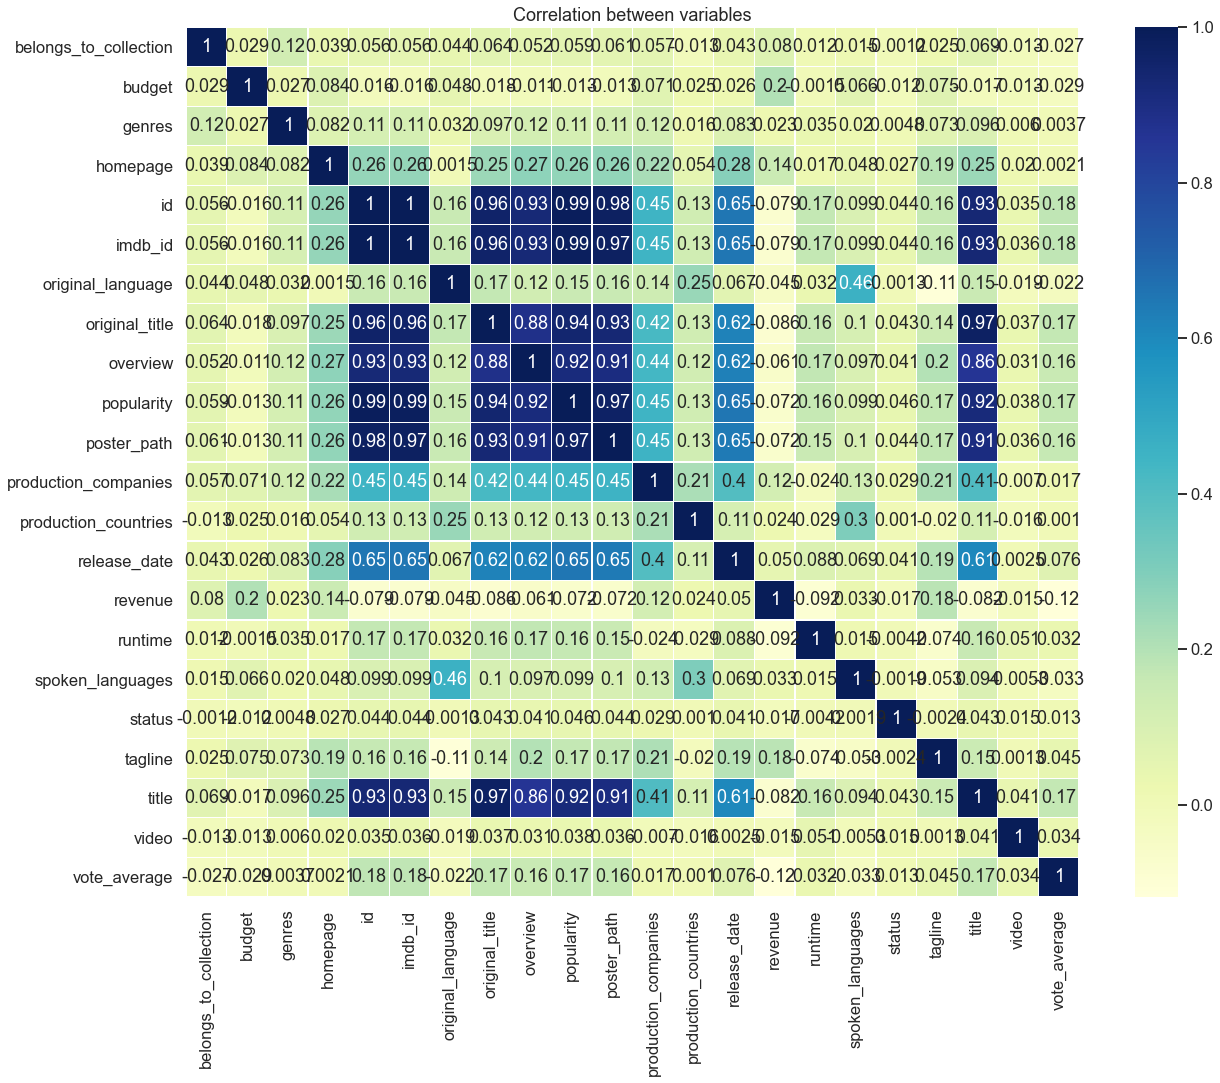

In [108]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=0.2, cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")

<AxesSubplot:>

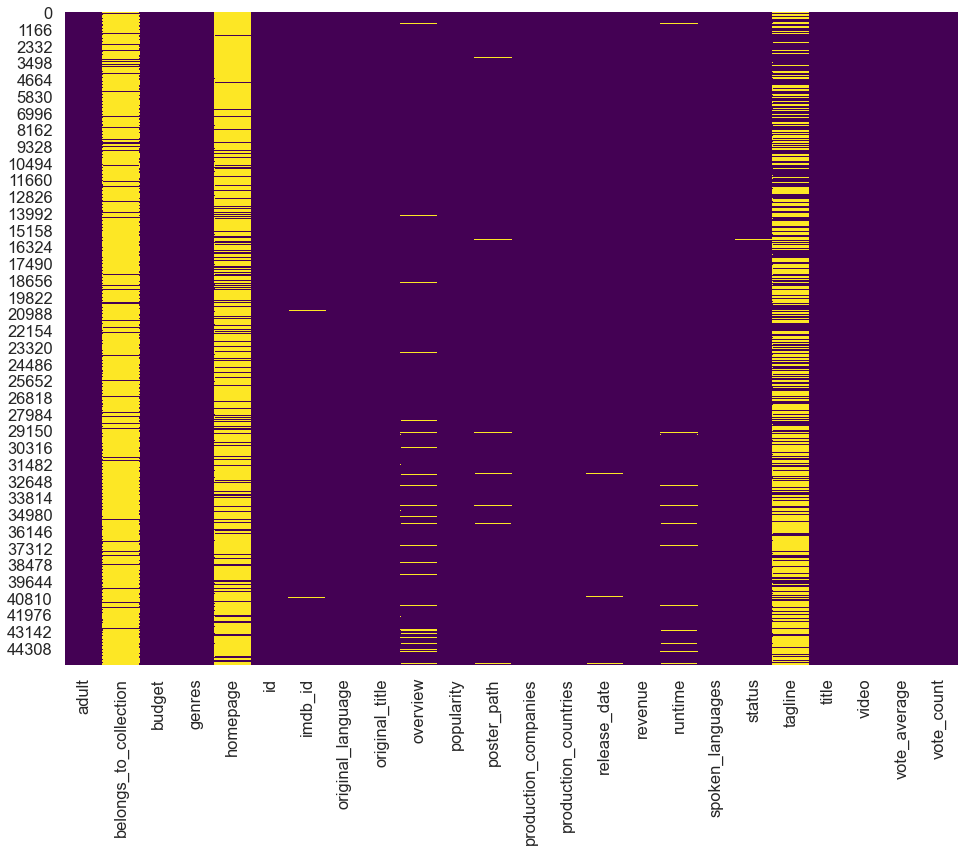

In [103]:
#plot missing values
plt.figure(figsize=(16,12))
sns.heatmap(movies_original.isnull(),cbar=False,cmap='viridis')

In [85]:
movies_df.columns

Index(['ID', 'IMDB ID', 'Title', 'Collection', 'Genres', 'Language',
       'Spoken Languages', 'Release Date', 'Runtime', 'Revenue',
       'Production Companies', 'Production Countries', 'Popularity Rating',
       'Vote Count', 'Vote Average', 'Keywords', 'Cast', 'Director', 'Writer',
       'Producer'],
      dtype='object')

<AxesSubplot:title={'center':'Popular Genres'}>

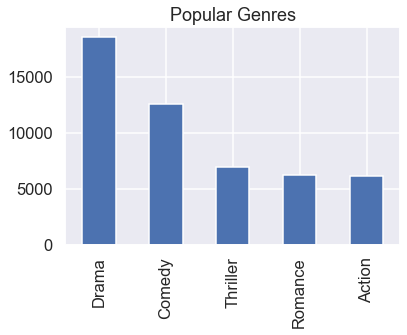

In [84]:
# see the top 5 genres in the dataset
genre_counts = pd.Series(movies_df['Genres'].sum()).value_counts()
genre_counts.head(5).plot(kind='bar', title='Popular Genres')

<AxesSubplot:title={'center':'Popular Keywords'}>

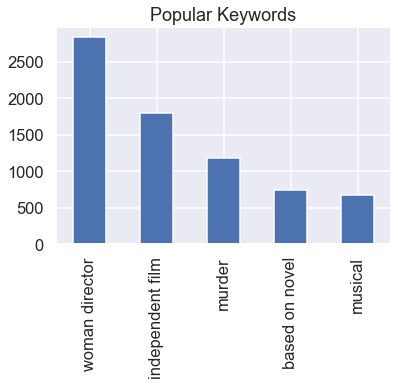

In [87]:
# see the top 5 Languages in the dataset
genre_counts = pd.Series(movies_df['Keywords'].sum()).value_counts()
genre_counts.head(5).plot(kind='bar', title='Popular Keywords')

Text(0, 0.5, 'VoteCount')

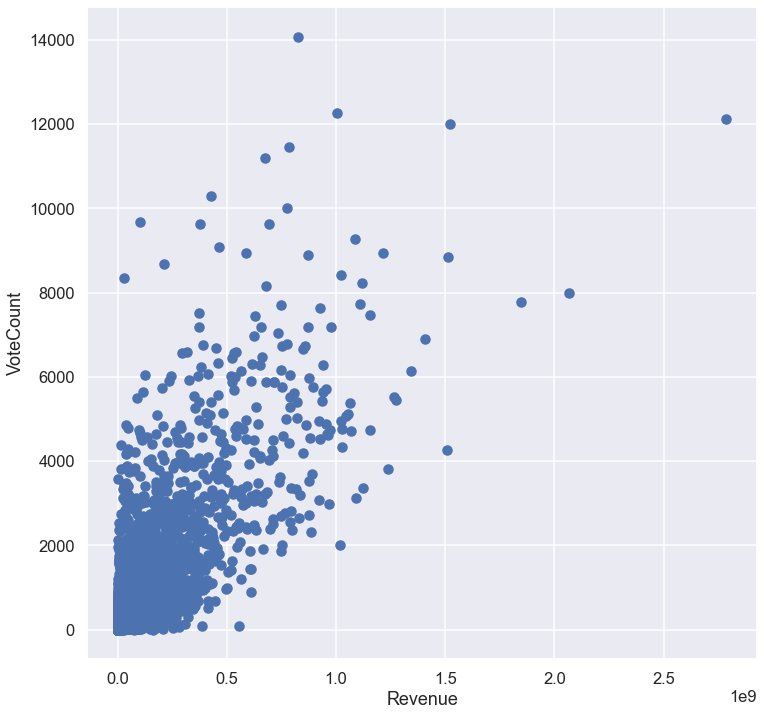

In [115]:
# How does the vote count is correlated to revenue
Revenue = movies_df['Revenue']
VoteCount = movies_df['Vote Count']
plt.figure(figsize=(12,12))
plt.scatter(x=Revenue,y=VoteCount)
plt.xlabel('Revenue')
plt.ylabel('VoteCount')

ValueError: could not convert string to float: 'Beware Of Frost Bites'

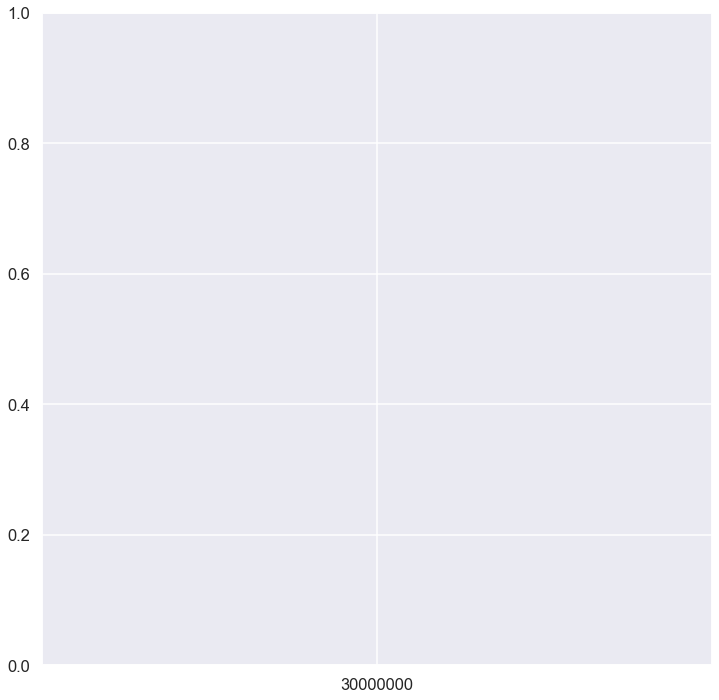

In [125]:
budget = movies_original['budget']
popularity = movies_original['popularity']
plt.figure(figsize=(12,12))
plt.scatter(x = budget,y = popularity)
plt.xlabel('budget')
plt.ylabel('vote')

In [11]:
# count NaN in each column
movies_df.isna().sum()

# Collection: most movies don't belong to a series 
# Revenue: missing data

ID                          0
IMDB ID                    14
Title                       1
Collection              37911
Genres                      0
Language                   11
Spoken Languages            0
Release Date               84
Runtime                   252
Revenue                 35122
Production Companies        1
Production Countries        1
Popularity Rating          66
Vote Count               2658
Vote Average             2745
Keywords                    0
Cast                        0
Director                  861
Writer                   9562
Producer                20984
dtype: int64

In [12]:
# see various languages movies were shot in
# mainly movies in English 
movies_df["Language"].value_counts().head(5)

en    30001
fr     2272
it     1461
ja     1286
de     1005
Name: Language, dtype: int64

In [13]:
# franchise movies
movies_fran = movies_df[movies_df['Collection'].notnull()]
'%d many movies belong to a collection' % movies_fran.shape[0]

'4367 many movies belong to a collection'

In [14]:
# revenue by collection
movies_fran_pivot = movies_fran.pivot_table(index='Collection', values='Revenue', aggfunc={'Revenue': [np.mean, np.sum, 'count']})
movies_fran_pivot = movies_fran_pivot.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot.head(20)

,Collection,count,mean,sum
0,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1,Star Wars Collection,8,9.293118e+08,7.434495e+09
2,James Bond Collection,25,2.826090e+08,7.065226e+09
3,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
4,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
5,Transformers Collection,5,8.732202e+08,4.366101e+09
6,Despicable Me Collection,4,9.227676e+08,3.691070e+09
7,The Twilight Collection,5,6.684215e+08,3.342107e+09
8,Ice Age Collection,5,6.433417e+08,3.216709e+09
9,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


In [15]:
# popularity rating 
movies_fran_pivot2 = movies_fran.pivot_table(index='Collection', values='Popularity Rating', aggfunc={'Popularity Rating': [np.mean, np.sum]})
movies_fran_pivot2 = movies_fran_pivot2.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot2.head(20)

,Collection,mean,sum
0,Despicable Me Collection,106.715961,640.295768
1,James Bond Collection,13.459622,336.490544
2,Wonder Woman Collection,294.337037,294.337037
3,Pirates of the Caribbean Collection,53.972237,269.861183
4,Planet of the Apes (Reboot) Collection,87.720253,263.160759
5,Guardians of the Galaxy Collection,119.311296,238.622593
6,John Wick Collection,116.558939,233.117879
7,The Hunger Games Collection,54.766747,219.066990
8,Harry Potter Collection,26.253893,210.031146
9,Avatar Collection,95.545473,191.090947


In [ ]:
## The correlation between Directors, Revene and Vote average

In [ ]:
## missing value 


### **User Ratings Data EDA**

In [16]:
# read in movie ratings 
ratings_df = pd.read_csv('Movies Data/ratings.csv')

# rename columns
ratings_df = ratings_df.rename(columns={"userId": "User ID", 
                                        "movieId": "Movie ID", 
                                        "timestamp": "Timestamp"})

In [17]:
ratings_df

,User ID,Movie ID,rating,Timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [18]:
print('%s many users' % ratings_df['User ID'].nunique())
print('%s many movies' % ratings_df['Movie ID'].nunique())

270896 many users
45115 many movies


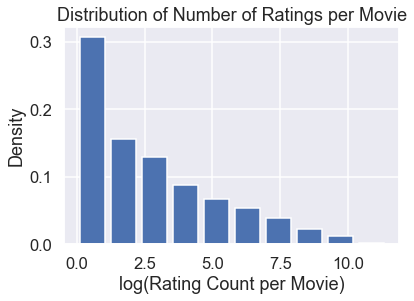

In [19]:
rating_count_per_movie = np.log(ratings_df['Movie ID'].value_counts().values)

plt.hist(rating_count_per_movie, density=True, rwidth=0.8)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('log(Rating Count per Movie)')
plt.ylabel('Density')
plt.show()

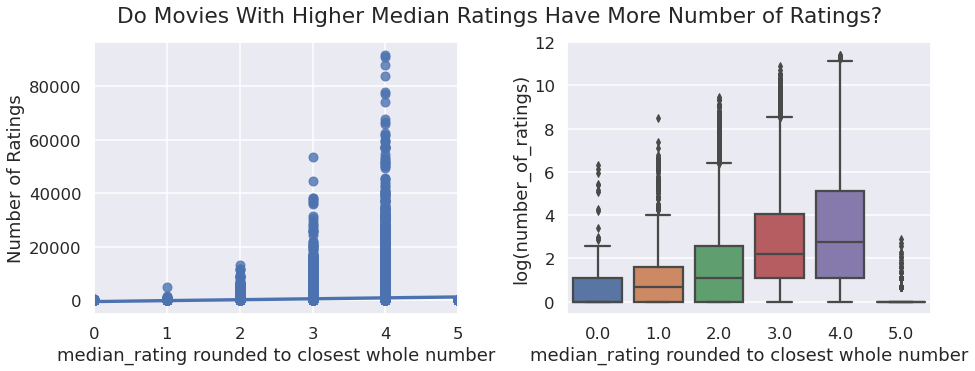

Linear Regression Results
Coefficient: 342
P-Val: 0


In [19]:
rating_per_number_of_ratings = ratings_df.groupby('Movie ID').agg({'User ID': 'count', 'rating': 'median'})
rating_per_number_of_ratings = rating_per_number_of_ratings.rename(columns={'User ID': 'number_of_ratings', 'rating': 'median_rating'})
rating_per_number_of_ratings = np.round(rating_per_number_of_ratings)

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Do Movies With Higher Median Ratings Have More Number of Ratings?')

sns.regplot(x='median_rating', y='number_of_ratings', data=rating_per_number_of_ratings, ax=axes[0])
axes[0].set_xlabel('median_rating rounded to closest whole number')
axes[0].set_ylabel('Number of Ratings')
slope, intercept, r_value, p_value, std_err = stats.linregress(rating_per_number_of_ratings['median_rating'],rating_per_number_of_ratings['number_of_ratings'])

sns.boxplot(x=rating_per_number_of_ratings["median_rating"], y=np.log(rating_per_number_of_ratings["number_of_ratings"]), ax=axes[1])
axes[1].set_xlabel('median_rating rounded to closest whole number')
axes[1].set_ylabel('log(number_of_ratings)')

plt.show()
print('Linear Regression Results\nCoefficient: %d\nP-Val: %d' % (slope, p_value))

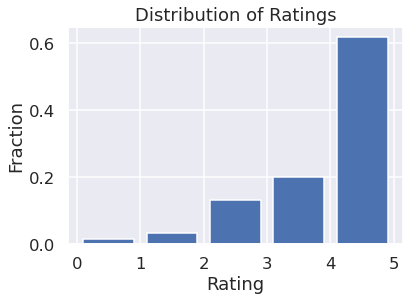

In [20]:
plt.hist(ratings_df['rating'].round(), density=True, rwidth=0.8, bins=5)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Fraction')
plt.show()

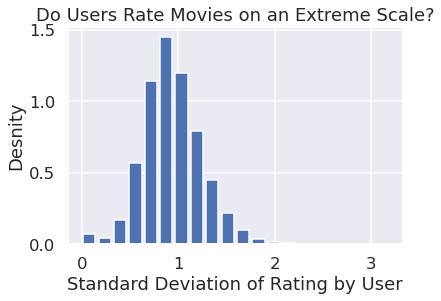

array([2.90515176, 3.32232727, 3.76682294, 3.65202692, 2.81517498,
       2.2278575 , 2.75141659, 3.23612858, 1.3109947 , 5.15660653])

In [21]:
std_of_rating_by_user = ratings_df.groupby('User ID')['rating'].agg(np.std)
plt.hist(std_of_rating_by_user, bins=20, density=True, rwidth=0.8)
plt.title('Do Users Rate Movies on an Extreme Scale?')
plt.xlabel('Standard Deviation of Rating by User')
plt.ylabel('Desnity')
plt.show()

np.random.normal(loc=3, scale=std_of_rating_by_user.median(), size=10)

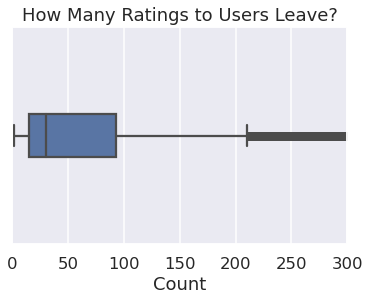

In [22]:
number_of_ratings_per_user = ratings_df.groupby('User ID')['rating'].count().values
ax = sns.boxplot(x=number_of_ratings_per_user, width=0.2)
ax.set_xlim([0, 300])
plt.title("How Many Ratings to Users Leave?")
plt.xlabel("Count")
plt.show()

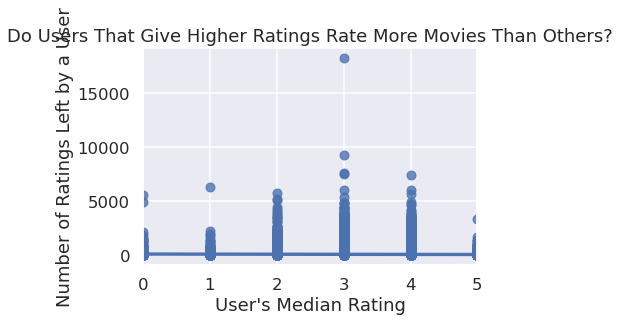

Linear Regression Results
Coefficient: -8
P-Val: 0


In [23]:
rating_count = ratings_df.groupby('User ID')['rating'].agg(['count', np.median])
rating_count['median'] = rating_count['median'].round()

sns.regplot(x="median", y="count", data=rating_count);
plt.title('Do Users That Give Higher Ratings Rate More Movies Than Others?')
plt.xlabel('User\'s Median Rating')
plt.ylabel('Number of Ratings Left by a User')
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(rating_count['median'],rating_count['count'])
print('Linear Regression Results\nCoefficient: %d\nP-Val: %d' % (slope, p_value))

In [26]:
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan
